In [1]:
!pip install pretty_errors
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2d3ad2136585f5c45d42f73c6c73eee6fc813f4fcb7b6a0f3bc21bdc86144e7f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!pip install sparkml_base_classes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/ML Project'

/content/drive/MyDrive/ML Project


In [3]:
from pyspark.sql import SparkSession
import os, sys, matplotlib.pyplot as plt, seaborn as sns
import pretty_errors

In [4]:
from config import PROJECT_PATH

In [5]:
sys.path.append(os.path.join(PROJECT_PATH, 'Source'))

In [6]:
from data_processing import *
from data_visualization import *

In [7]:
train_dir = os.path.join(PROJECT_PATH, 'Datasets/finalTrain.csv')
test_dir = os.path.join(PROJECT_PATH, 'Datasets/finalTest.csv')

In [8]:
from pyspark.sql import functions as F
import pandas as pd
import numpy as np

In [9]:
sc = SparkSession.builder \
    .appName("fraudDetection") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
train = sc.read.csv(train_dir, inferSchema = True, header = True)
test = sc.read.csv(test_dir, inferSchema = True, header = True)

In [10]:
train, test = train.drop('_c0'), test.drop('_c0')

In [11]:
train.show()

+------+----+----------+-----+--------+
|   amt| age|trans_hour|state|is_fraud|
+------+----+----------+-----+--------+
|  4.97|36.0|         0|   NC|       0|
|107.23|46.0|         0|   WA|       0|
|220.11|62.0|         0|   ID|       0|
|  45.0|57.0|         0|   MT|       0|
| 41.96|38.0|         0|   VA|       0|
| 94.63|63.0|         0|   PA|       0|
| 44.54|31.0|         0|   KS|       0|
| 71.65|77.0|         0|   VA|       0|
|  4.27|83.0|         0|   PA|       0|
|198.39|50.0|         0|   TN|       0|
| 24.74|34.0|         0|   IA|       0|
|  7.77|58.0|         0|   WV|       0|
| 71.22|35.0|         0|   FL|       0|
| 96.29|79.0|         0|   CA|       0|
|  7.77|57.0|         0|   NM|       0|
|  3.26|59.0|         0|   NJ|       0|
| 327.0|72.0|         0|   OK|       0|
|341.67|86.0|         0|   IN|       0|
| 63.07|78.0|         0|   PA|       0|
| 44.71|44.0|         0|   NJ|       0|
+------+----+----------+-----+--------+
only showing top 20 rows



In [12]:
print(f'Train shape: {train.count()}, {len(train.columns)}')
print(f'Test shape: {test.count()}, {len(test.columns)}')

Train shape: 1296675, 5
Test shape: 555719, 5


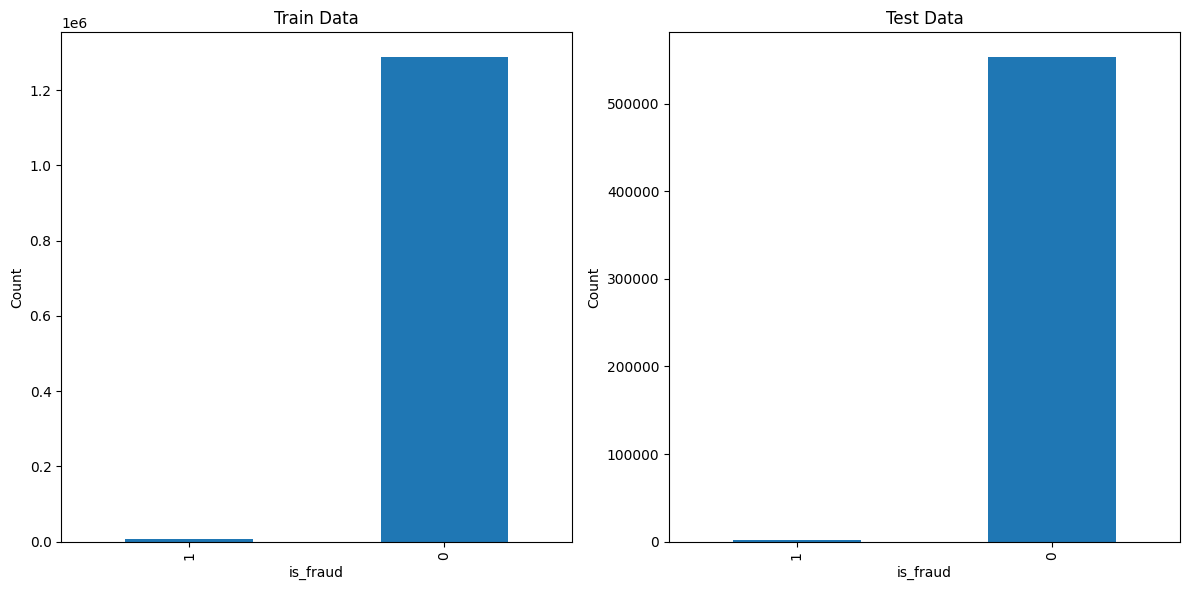

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
train.select('is_fraud').groupby('is_fraud').count().toPandas().plot(kind = "bar", x = "is_fraud", y = "count", ax = axes[0], legend = False)
test.select('is_fraud').groupby('is_fraud').count().toPandas().plot(kind = "bar", x = "is_fraud", y = "count", ax = axes[1], legend = False)
axes[0].set_title("Train Data")
axes[0].set_xlabel("is_fraud")
axes[0].set_ylabel("Count")
axes[1].set_title("Test Data")
axes[1].set_xlabel("is_fraud")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.mllib.evaluation import MulticlassMetrics

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [16]:
log_transformer = LogTransformer(input_col = 'amt', output_col = 'log_amt')

In [17]:
string_indexer = StringIndexer(inputCol = 'state', outputCol = 'state_idx')
encoder = OneHotEncoder(inputCols = ['state_idx'], outputCols = ['state_vec'])
assembler = VectorAssembler(inputCols = ['log_amt', 'state_vec', 'trans_hour', 'age'], outputCol = 'features')

In [18]:
dct = DecisionTreeClassifier(labelCol = 'is_fraud', featuresCol = 'features')

In [28]:
pipeline = Pipeline(stages = [log_transformer, string_indexer, encoder, assembler])
pipeline = pipeline.fit(train)
transformed_train, transformed_test = pipeline.transform(train), pipeline.transform(test)

In [29]:
dct_model = dct.fit(transformed_train)
train_preds, test_preds = dct_model.transform(transformed_train), dct_model.transform(transformed_test)

In [30]:
evaluator = BinaryClassificationEvaluator(labelCol = 'is_fraud')
train_auc, test_auc = evaluator.evaluate(train_preds), evaluator.evaluate(test_preds)
print(f"Train Area under ROC curve: {train_auc}")
print(f"Test Area under ROC curve: {test_auc}")

Train Area under ROC curve: 0.14047677505724046
Test Area under ROC curve: 0.14445369927274782


In [43]:
labels_and_preds = test_preds.select(F.col('prediction').cast('double'), F.col('is_fraud').cast('double')) \
                              .rdd \
                              .map(lambda row: (row['prediction'], row['is_fraud']))
metrics = MulticlassMetrics(labels_and_preds)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([[5.53404e+05, 1.70000e+02],
       [1.44500e+03, 7.00000e+02]])